In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
import skimage.filters as skf
import sys
import warnings
from scipy import ndimage as scnd
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH_RECIPROCAL
from matplotlib.offsetbox import AnchoredText
import math
import sys
import numba
from skimage.transform import rescale as skitres
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'figure.autolayout': True})

In [2]:
warnings.filterwarnings('ignore')
sys.path.append('/home/cades/Codes/stemtools')
sys.path.append('/home/cades/Codes/ptychogpu/pty')
#sys.path.append('C:/Debangshu Research/stemtools')
#sys.path.append('C:/Debangshu Research/ptycho_testing/ptychogpu/pty')
import stemtools as st
import cpu_ssb
%load_ext autoreload
%autoreload 2

In [3]:
data_num = 'Data1'
st.tic()
Data_4D = np.load('/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/'+data_num+'_4D.npy')
json_4D = '/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/'+data_num+'_4D.json'
DataADF = np.load('/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/'+data_num+'_ADF.npy')
jsonADF = '/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/'+data_num+'_ADF.json'
with open(json_4D) as json__4D:
    info_4D = json.load(json__4D)
with open(jsonADF) as json_ADF:
    infoADF = json.load(json_ADF)
st.toc()

Elapsed time: 7.168135 seconds.



In [4]:
scan_calib_vals = infoADF['spatial_calibrations'][0]['scale']
scan_calib_unit = infoADF['spatial_calibrations'][0]['units']

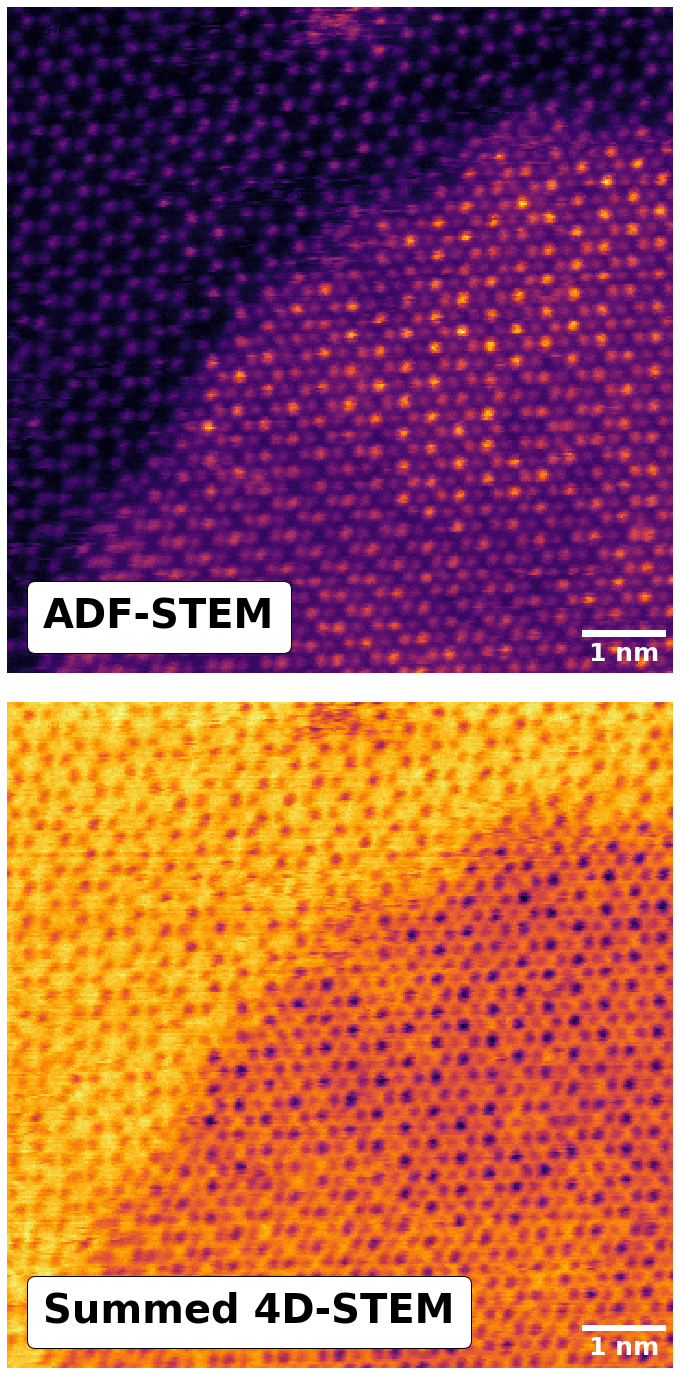

In [5]:
plt.figure(figsize=(10,20))
plt.subplot(2,1,1)
plt.imshow(DataADF)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')
at = AnchoredText('ADF-STEM',
                  prop=dict(size=int(40)), frameon=True,
                  loc='lower left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)

plt.subplot(2,1,2)
plt.imshow(np.sum(Data_4D,axis=(-1,-2)))
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')
at = AnchoredText('Summed 4D-STEM',
                  prop=dict(size=int(40)), frameon=True,
                  loc='lower left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)

plt.tight_layout()
plt.savefig('/home/cades/dpc/ADF_BF.pdf',bbox_inches='tight')

In [6]:
st.tic()
Flat4D = np.reshape(Data_4D,(Data_4D.shape[0]*Data_4D.shape[1],Data_4D.shape[2],Data_4D.shape[3]))
CentralDisk = np.median(Flat4D,axis=0)
st.toc()

Elapsed time: 158.506589 seconds.



Text(0.5, 1.0, 'Diffraction Disk')

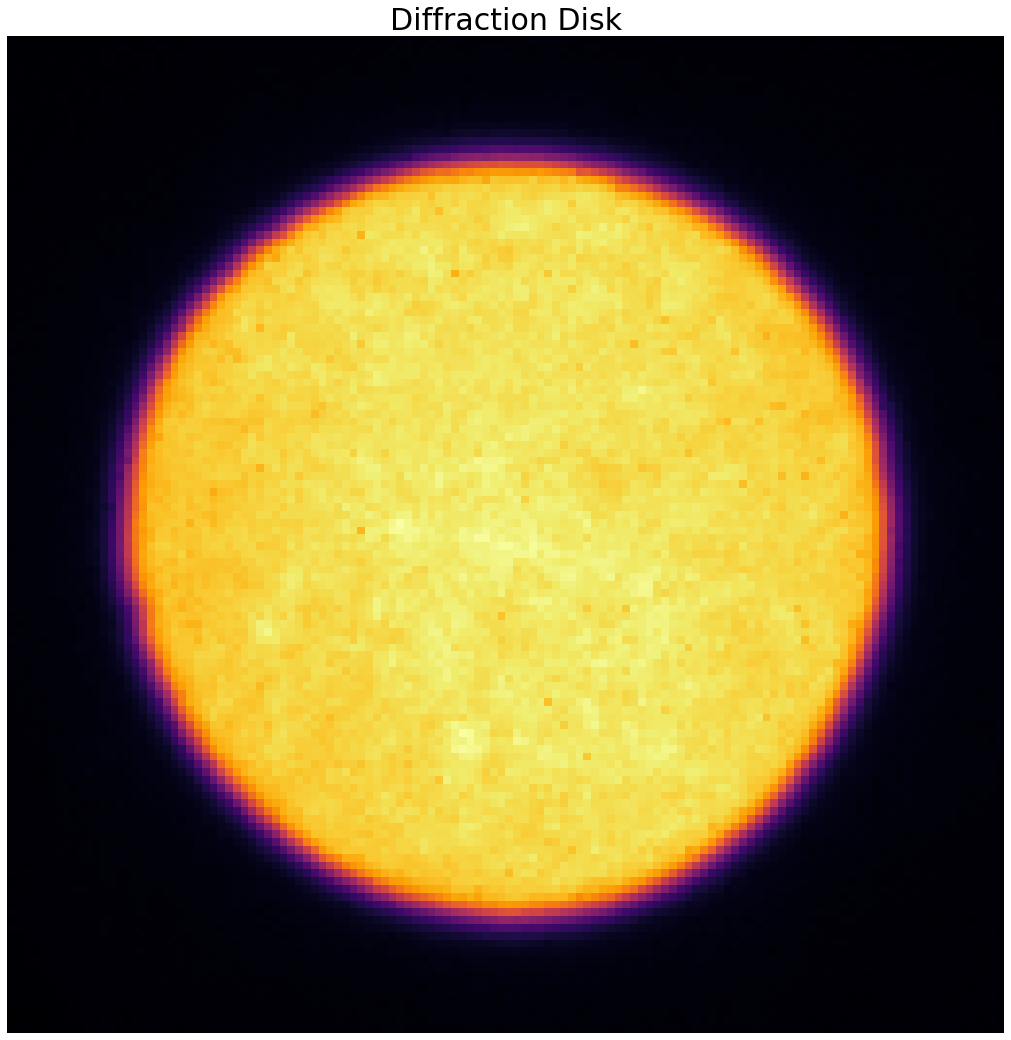

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(CentralDisk)
plt.axis('off')
plt.title('Diffraction Disk')
#plt.savefig('C:/Debangshu Research/ptycho_testing/CPU Results/Diffraction Disks.pdf')

In [8]:
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)

In [9]:
beam_x,beam_y,beam_r

(63.9882504247423, 63.39050876281728, 48.76387658221216)

In [10]:
@numba.jit
def get_flat_dpc(data4D_flat):
    CentralDisk = np.mean(data4D_flat,axis=0)
    beam_x,beam_y,_ = st.util.sobel_circle(CentralDisk)
    yy, xx = np.mgrid[0:data4D_flat.shape[1],0:data4D_flat.shape[2]]
    YCom = np.zeros(data4D_flat.shape[0],dtype=np.float)
    XCom = np.zeros(data4D_flat.shape[0],dtype=np.float)
    for ii in numba.prange(data4D_flat.shape[0]):
        cbed = data4D_flat[ii,:,:]
        YCom[ii] = (np.sum(np.multiply(yy,cbed))/np.sum(cbed)) - beam_y
        XCom[ii] = (np.sum(np.multiply(xx,cbed))/np.sum(cbed)) - beam_x
    return XCom,YCom

In [28]:
%timeit get_flat_dpc(Flat4D[0:100,:,:])

75.7 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
st.tic()
dpc_x,dpc_y = get_flat_dpc(Flat4D)
dpc_x = np.reshape(dpc_x,(Data_4D.shape[0],Data_4D.shape[1]))
dpc_y = np.reshape(dpc_y,(Data_4D.shape[0],Data_4D.shape[1]))
st.toc()

Elapsed time: 39.000710 seconds.



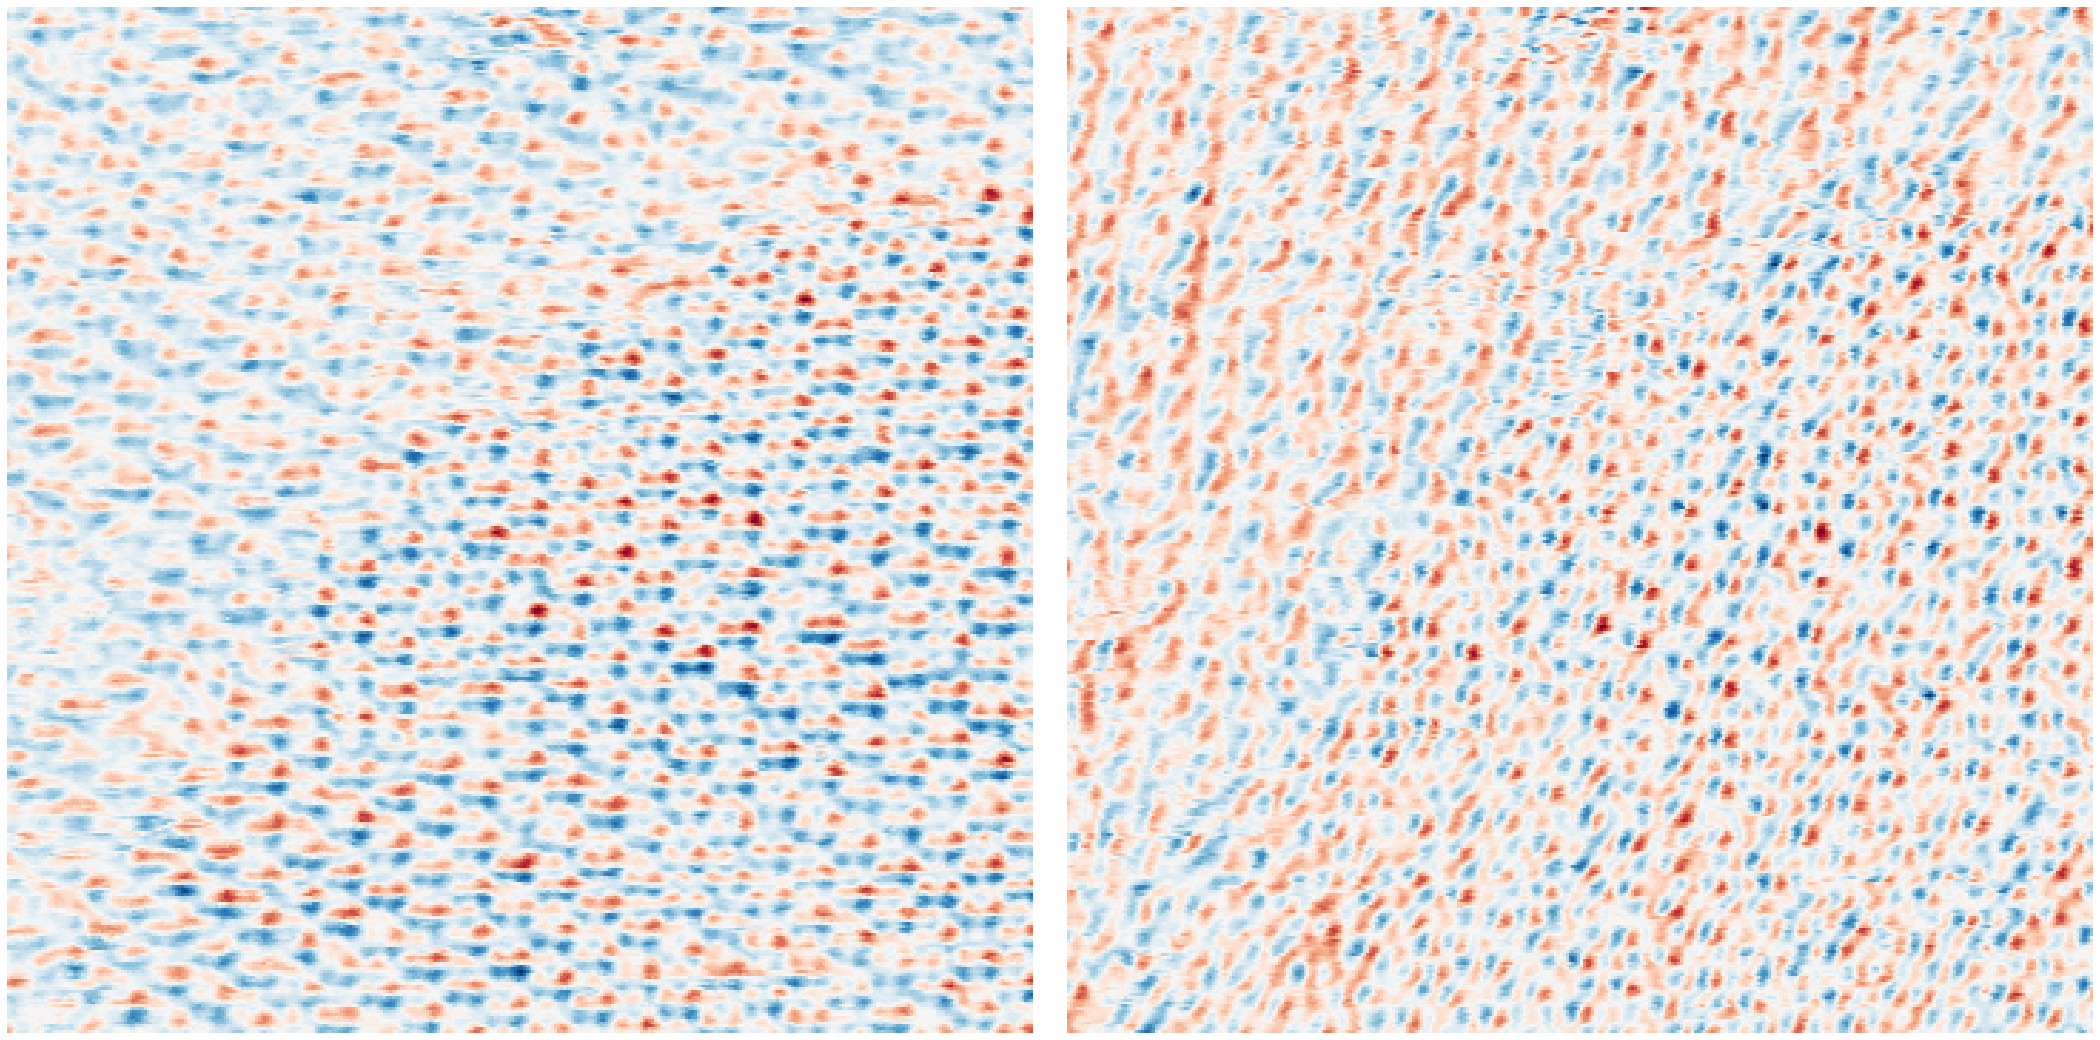

In [30]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_x,cmap='RdBu_r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dpc_y,cmap='RdBu_r')
plt.axis('off')
plt.tight_layout()
#plt.savefig('C:/Debangshu Research/ptycho_testing/CPU Results/Raw DPC.pdf')

In [31]:
st.tic()
rotangle,flipval = cpu_ssb.optimize_angle(dpc_x,dpc_y,DataADF)
dpc_xC,dpc_yC = cpu_ssb.corrected_dpc(dpc_x,dpc_y,rotangle,flipval)
st.toc()

Elapsed time: 2.650720 seconds.



In [32]:
rotangle

-102.66584042558911

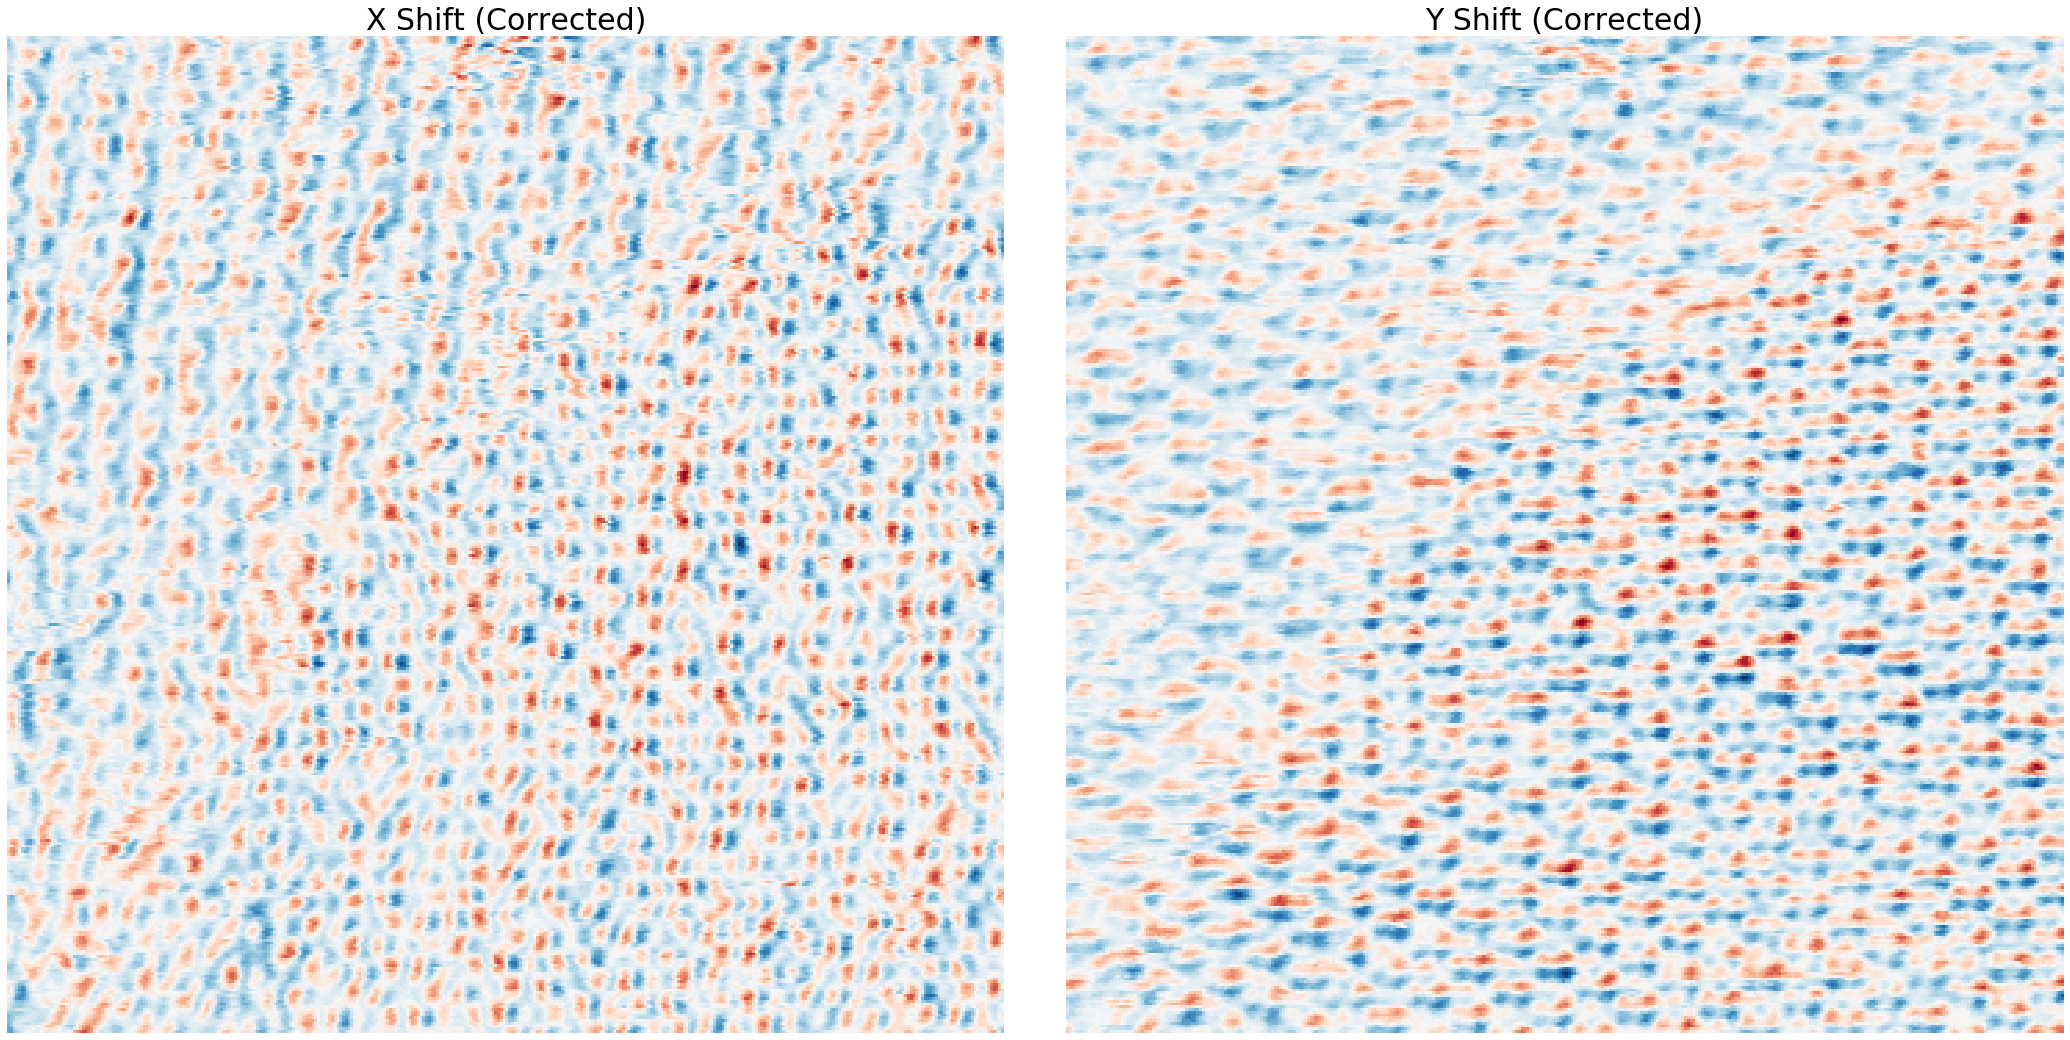

In [33]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_xC,cmap='RdBu_r')
plt.axis('off')
plt.title('X Shift (Corrected)')
plt.subplot(1,2,2)
plt.imshow(dpc_yC,cmap='RdBu_r')
plt.axis('off')
plt.title('Y Shift (Corrected)')
plt.tight_layout()
#plt.savefig('C:/Debangshu Research/ptycho_testing/CPU Results/Corrected DPC.pdf')

In [48]:
cc_cut = cc_color[cutstart[0]:xpos.shape[0],cutstart[1]:xpos.shape[1],:]

(315, 45)

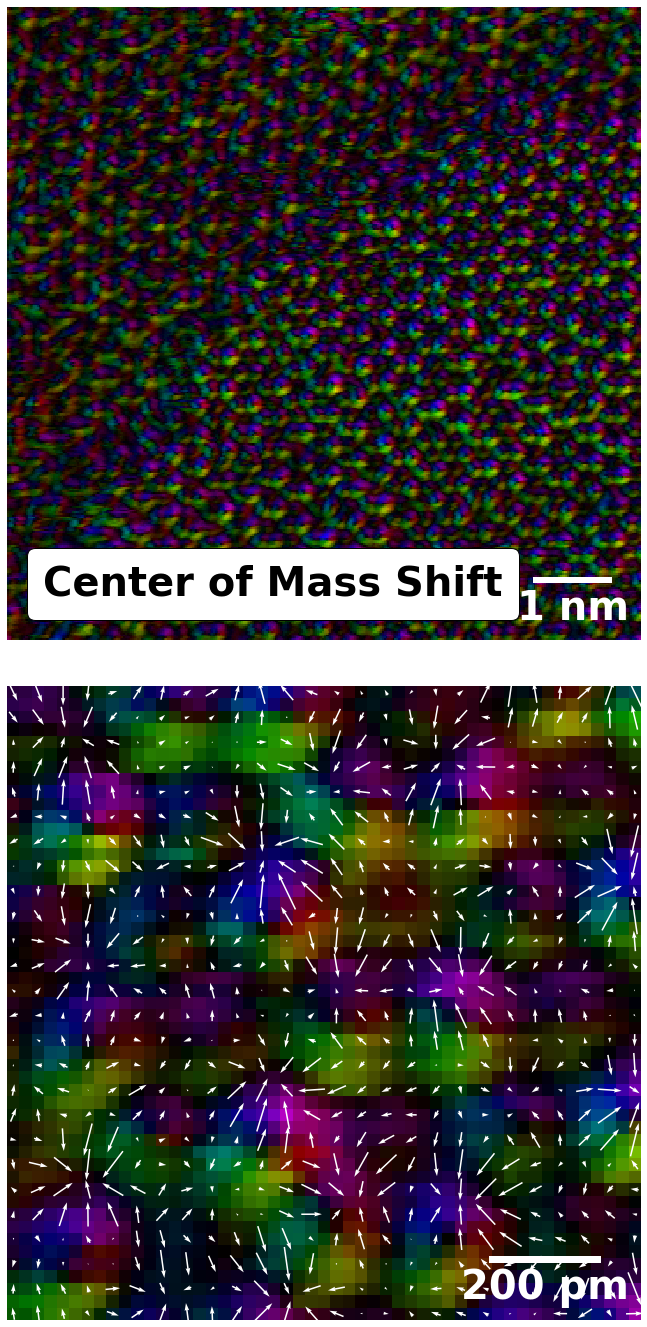

In [73]:
skip = 2
import matplotlib as mpl
sc_font={'weight' : 'bold',
         'size'   : 40}
mpl.rc('font', **sc_font)
cc = dpc_xC+ ((1j)*dpc_yC)
cc_color = st.util.cp_image_val(cc)
cutter = 1/7
cutstart = (np.round(np.asarray(dpc_xC.shape) - (cutter*np.asarray(dpc_xC.shape)))).astype(int)
ypos, xpos = np.mgrid[0:dpc_yC.shape[0],0:dpc_xC.shape[1]]
ypos = ypos
xcut = xpos[cutstart[0]:dpc_xC.shape[0],cutstart[1]:dpc_xC.shape[1]] - cutstart[1]
ycut = np.flipud(ypos[cutstart[0]:dpc_xC.shape[0],cutstart[1]:dpc_xC.shape[1]]) - cutstart[0]
dx = dpc_xC[cutstart[0]:dpc_xC.shape[0],cutstart[1]:dpc_xC.shape[1]]
dy = dpc_yC[cutstart[0]:dpc_xC.shape[0],cutstart[1]:dpc_xC.shape[1]]
cc_cut = cc_color[cutstart[0]:dpc_xC.shape[0],cutstart[1]:dpc_xC.shape[1],:]

plt.figure(figsize=(10,20))
plt.subplot(2,1,1)
plt.imshow(cc_color)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')
at = AnchoredText('Center of Mass Shift',
                  prop=dict(size=int(40)), frameon=True,
                  loc='lower left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)

plt.subplot(2,1,2)
plt.imshow(cc_cut)
plt.quiver(xcut[::skip,::skip],ycut[::skip,::skip],dx[::skip,::skip],dy[::skip,::skip],pivot='mid',color='w')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')
plt.tight_layout()
plt.savefig('/home/cades/dpc/DPC.pdf',bbox_inches='tight')

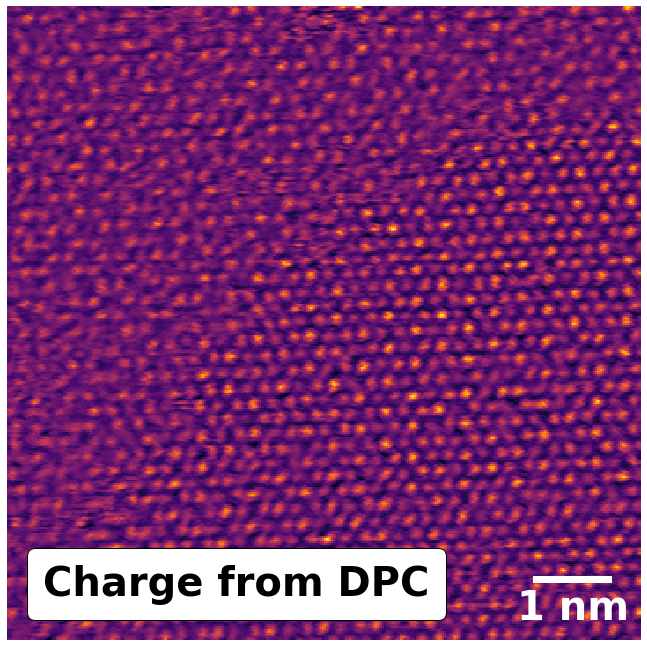

In [81]:
plt.figure(figsize=(10,10))
plt.imshow(-cpu_ssb.charge_dpc(dpc_xC,dpc_yC))
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')
at = AnchoredText('Charge from DPC',
                  prop=dict(size=int(40)), frameon=True,
                  loc='lower left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.tight_layout()
plt.savefig('/home/cades/dpc/Charge_DPC.pdf',bbox_inches='tight')

In [81]:
st.tic()
Flat4D = cpu_ssb.centerCBED(Flat4D,beam_x,beam_y)
CentralDisk = np.median(Flat4D,axis=0)
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)
st.toc()

Elapsed time: 621.952582 seconds.



In [ ]:
beam_x,beam_y,beam_r

In [17]:
%timeit cpu_ssb.resizer2D(CentralDisk,(76/112))

268 µs ± 45.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit cpu_ssb.resizer4Df(Flat4D[0:100,:,:],2)

9.54 ms ± 96.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit cpu_ssb.subpixel_pad4D(cpu_ssb.resizer4Df(Flat4D[0:100,:,:],2),Data_4D.shape[0:2],27)

224 ms ± 8.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


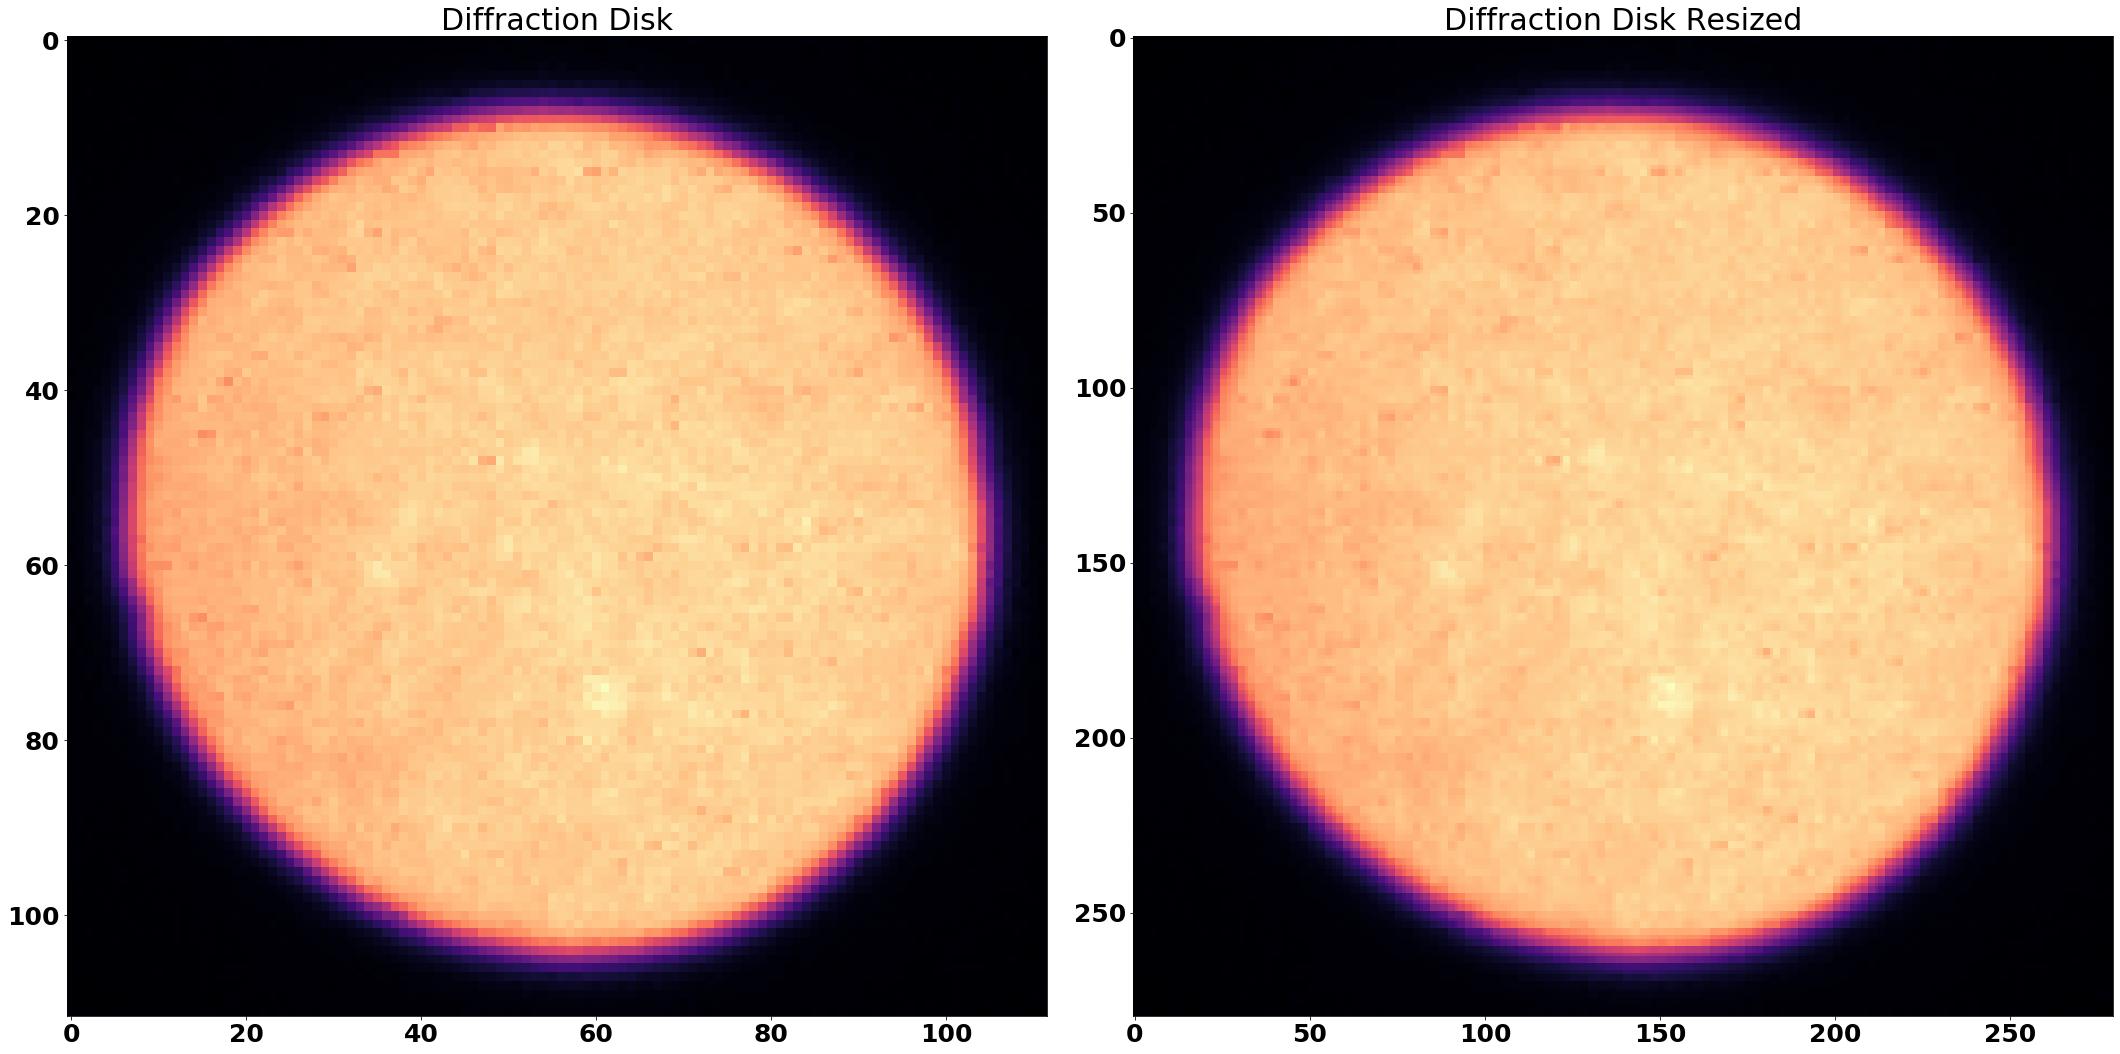

In [20]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(CentralDisk)
plt.title('Diffraction Disk')
plt.subplot(1,2,2)
plt.imshow(cpu_ssb.resizer2D(CentralDisk,0.4))
plt.title('Diffraction Disk Resized')
plt.savefig('C:/Debangshu Research/ptycho_testing/CPU Results/Resizing Test.pdf')

In [21]:
calib = infoADF['spatial_calibrations'][0]['scale']
calib_pm = 1000*calib

In [22]:
st.tic()
cbed_sampler = cpu_ssb.get_sampling(Data_4D.shape,32,60,calib_pm,beam_r)
Flat4DR = cpu_ssb.resizer4Df(Flat4D,cbed_sampler)
st.toc()

Elapsed time: 6.464811 seconds.



In [23]:
beam_r/cbed_sampler

26.324145232506833

In [24]:
st.tic()
new_radius = beam_r/cbed_sampler
Flat4DP = cpu_ssb.subpixel_pad4D(Flat4DR,Data_4D.shape[0:2],new_radius)
st.toc()

Elapsed time: 80.817054 seconds.



In [25]:
del Flat4DR

In [26]:
del Flat4D

In [27]:
st.tic()
Flat4DP = scnd.rotate(Flat4DP,rotangle,axes=(1,2),reshape=False)
st.toc()

Elapsed time: 161.836064 seconds.



In [28]:
st.tic()
Flat4DP = Flat4DP.astype(np.float32)
st.toc()

Elapsed time: 4.325098 seconds.



In [29]:
st.tic()
new_centraldisk = np.median(Flat4DP,axis=0)
st.toc()

Elapsed time: 58.401701 seconds.



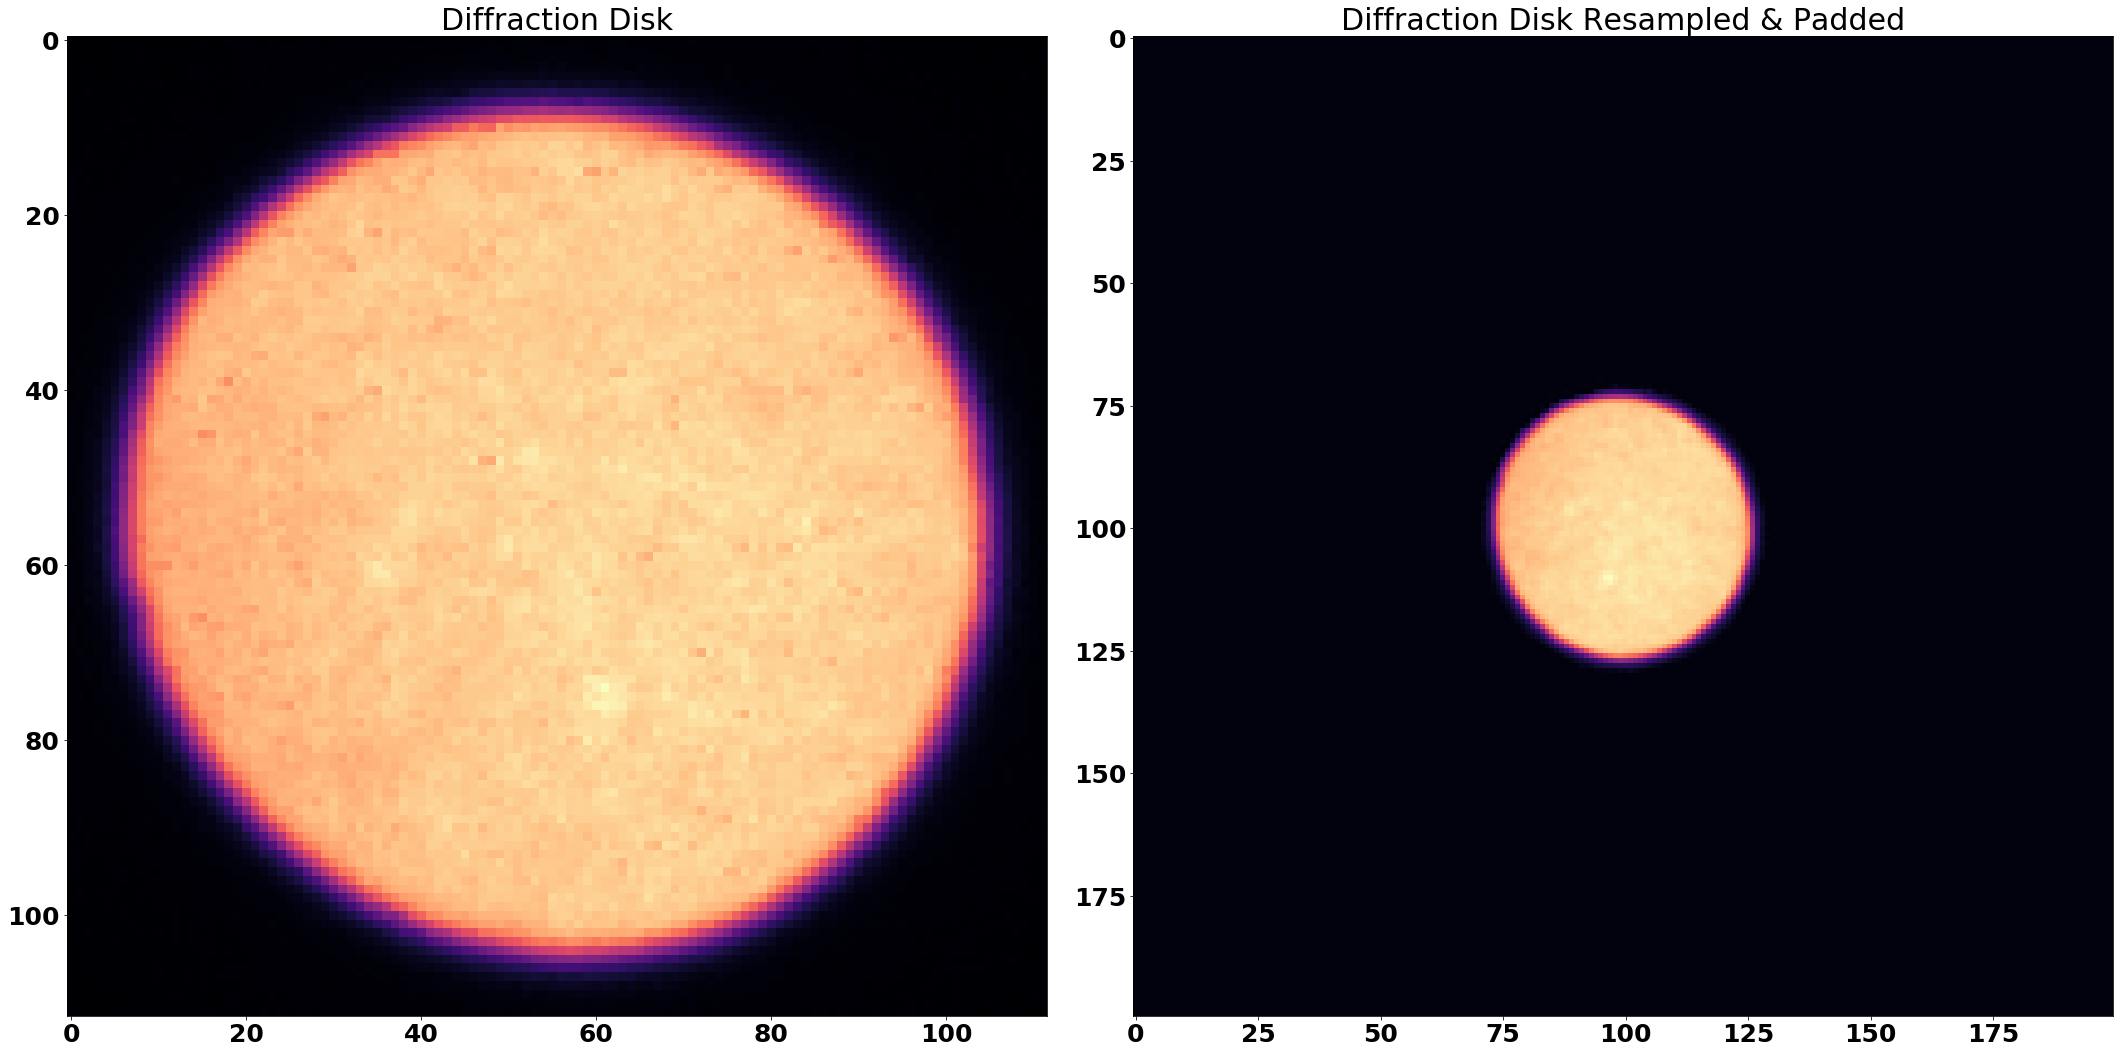

In [30]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(CentralDisk)
plt.title('Diffraction Disk')
plt.subplot(1,2,2)
plt.imshow(new_centraldisk)
plt.title('Diffraction Disk Resampled & Padded')
plt.savefig('C:/Debangshu Research/ptycho_testing/CPU Results/Resampled and padded diffraction disk.pdf')

In [31]:
st.tic()
Processed4D = np.reshape(Flat4DP,(Flat4DP.shape[1],Flat4DP.shape[2],Flat4DP.shape[1],Flat4DP.shape[2]))
Processed4D = cpu_ssb.get_G_matrix(Processed4D)
st.toc()

Elapsed time: 122.437343 seconds.



In [32]:
del Flat4DP

In [33]:
st.tic()
LSB,RSB = cpu_ssb.ssb_kernel(Processed4D,calib_pm,32,60)
st.toc()

Elapsed time: 310.335530 seconds.



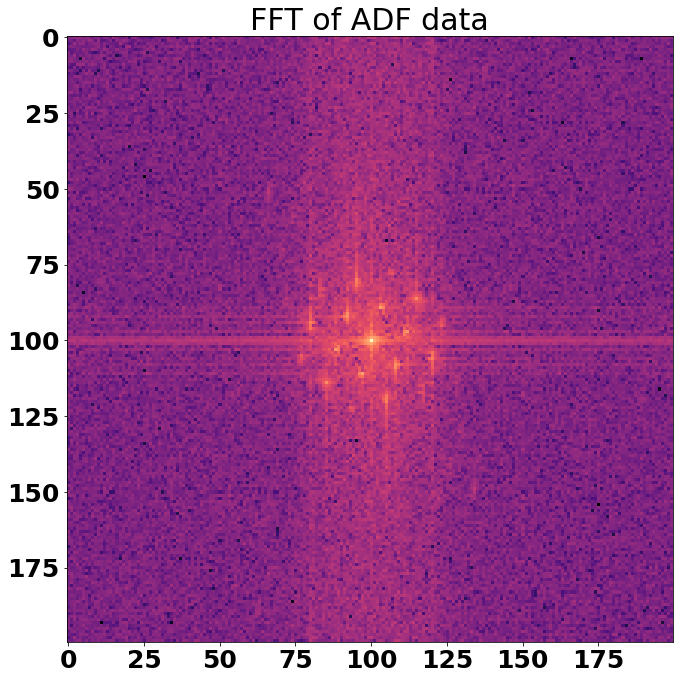

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(DataADF)))))
plt.title('FFT of ADF data')
plt.savefig('C:/Debangshu Research/ptycho_testing/CPU Results/ADF FFT.pdf')

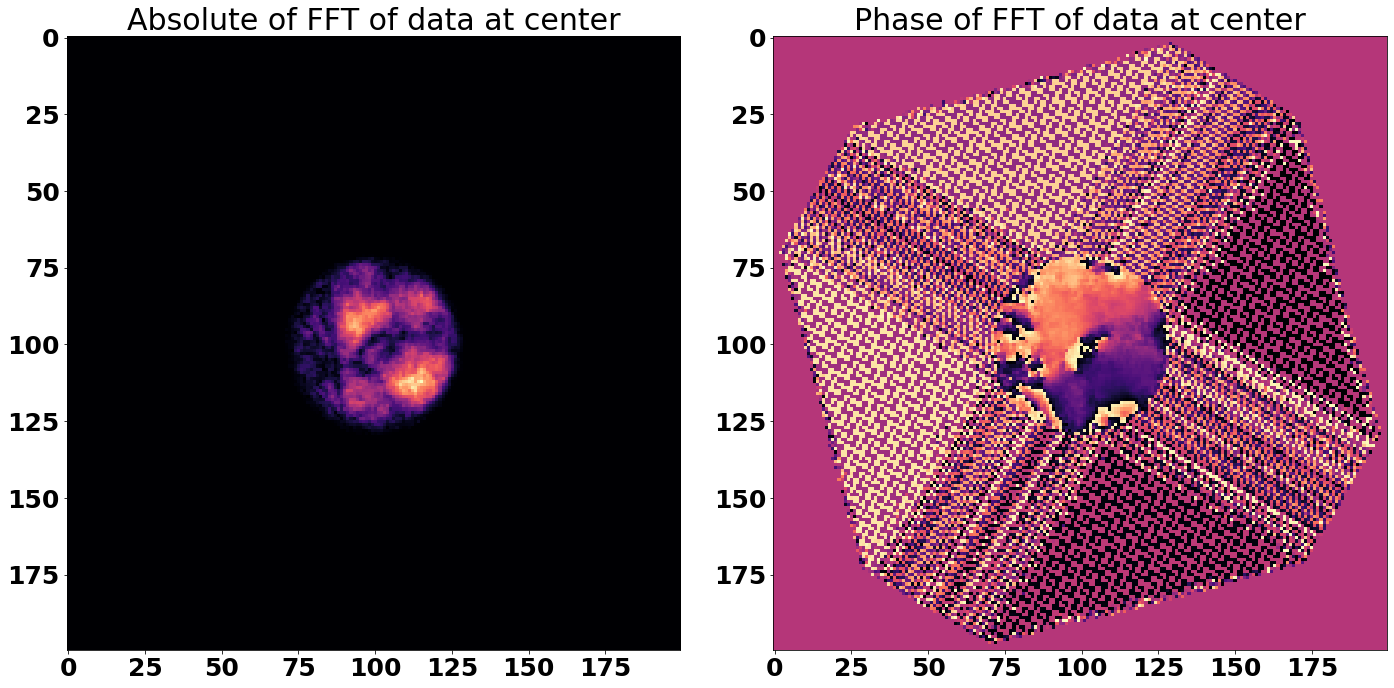

In [35]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(np.abs(Processed4D[:,:,87,120]))
plt.title('Absolute of FFT of data at center')

plt.subplot(1,2,2)
plt.imshow(np.angle(Processed4D[:,:,87,120]))
plt.title('Phase of FFT of data at center')
plt.savefig('C:/Debangshu Research/ptycho_testing/CPU Results/Amplitude and phase of trotters.pdf')

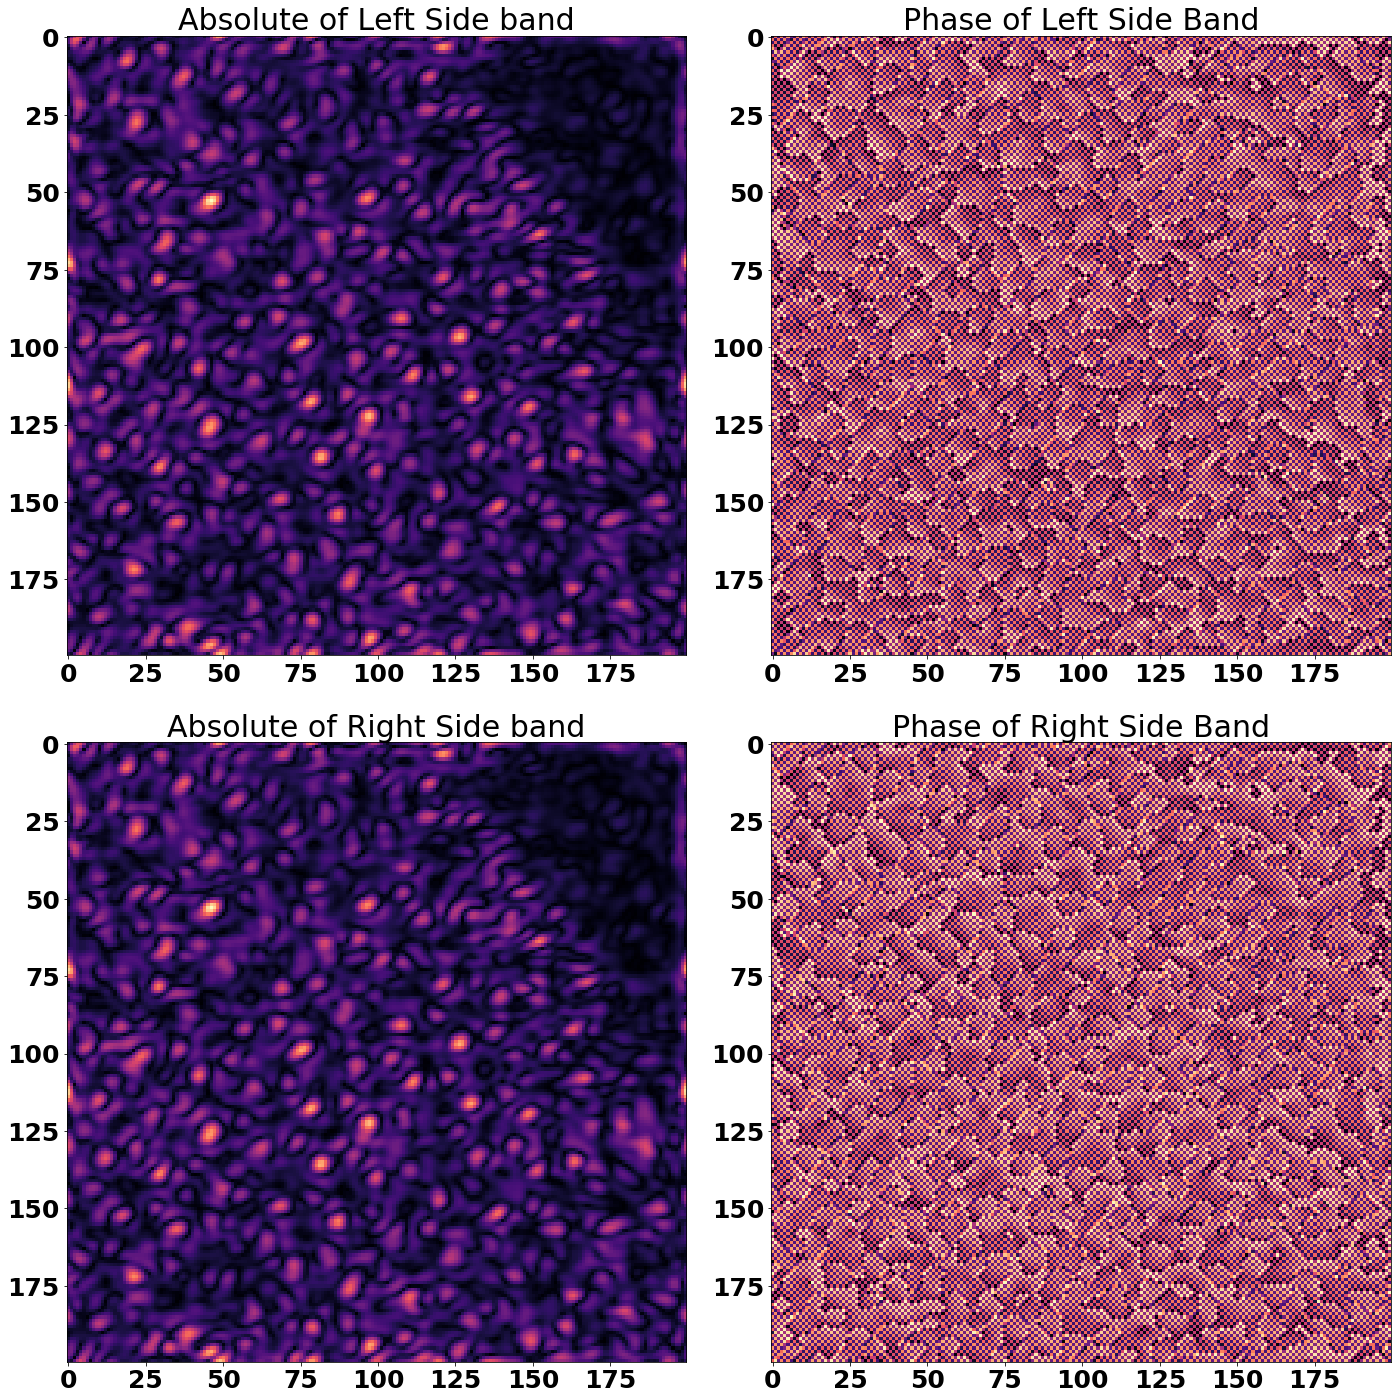

In [36]:
plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.imshow(np.abs(LSB))
plt.title('Absolute of Left Side band')

plt.subplot(2,2,2)
plt.imshow(np.angle(LSB))
plt.title('Phase of Left Side Band')

plt.subplot(2,2,3)
plt.imshow(np.abs(RSB))
plt.title('Absolute of Right Side band')

plt.subplot(2,2,4)
plt.imshow(np.angle(RSB))
plt.title('Phase of Right Side Band')
plt.savefig('C:/Debangshu Research/ptycho_testing/CPU Results/SSB Results.pdf')